In [1]:
import azureml.core
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")
print("")

# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

ws = Workspace.from_config(auth=interactive_auth)
print('Workspace name: ' + ws.name, sep='\n')

You are currently using version 1.8.0 of the Azure ML SDK

Workspace name: team20


In [3]:
from azureml.core import Dataset

aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


In [7]:
import sys
sys.path.append('../scripts')

from pipeline import StupidModel, run, validate_on_holdout

In [9]:
import pandas as pd
import numpy as np

data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

In [10]:
data_backup = data.copy()

In [50]:
from importlib import reload
import pipeline
reload(pipeline)
from pipeline import StupidModel, run, validate_on_holdout

In [17]:
pd.options.mode.chained_assignment = None

In [24]:
params = {'n_estimators': 5, 'eval_metric': ['ndcg', 'map'], 'verbose': True}
model = StupidModel(params)
score, model, scaled_test, scaled_control, preds = validate_on_holdout(data, model, verbose=True)
print(score)

Обучаем модель на тестовой группе:
[0]	eval_0-ndcg:0.87131	eval_0-map:0.303736
[1]	eval_0-ndcg:0.871537	eval_0-map:0.303722
[2]	eval_0-ndcg:0.871604	eval_0-map:0.301612
[3]	eval_0-ndcg:0.871765	eval_0-map:0.30365
[4]	eval_0-ndcg:0.87189	eval_0-map:0.305832

Обучаем модель на контрольной группе:
[0]	eval_0-ndcg:0.849635	eval_0-map:0.300214
[1]	eval_0-ndcg:0.85054	eval_0-map:0.302195
[2]	eval_0-ndcg:0.850756	eval_0-map:0.310033
[3]	eval_0-ndcg:0.858455	eval_0-map:0.330558
[4]	eval_0-ndcg:0.85906	eval_0-map:0.330153
{'train': 1.1915161985848897, 'test': 1.0653875742612895, 'train_random': 0.7867898411214616, 'test_random': 0.6414885071101472}


In [25]:
from scipy.stats import spearmanr, pearsonr

print('Spearman: ', spearmanr(scaled_test[:,0], scaled_control[:,0]))
print('Pearson: ', pearsonr(scaled_test[:,0], scaled_control[:,0]))

Spearman:  SpearmanrResult(correlation=0.9923198319455281, pvalue=0.0)
Pearson:  (0.9935372677592385, 0.0)


In [57]:
import xgboost as xgb
params = {'n_estimators': 20, 'eval_metric': ['logloss', 'auc', 'error'], 'verbose': True}
model1 = xgb.sklearn.XGBClassifier(**params)
model2 = xgb.sklearn.XGBClassifier(**params)
model = StupidModel(scale=False, test_model=model1, control_model=model2, ranking=False)

In [48]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, stratify=data['group'],
                                   shuffle=True)
model.fit(train.drop(['group', 'response_att'], axis=1), train['response_att'], train['group'],
              eval_data=(test.drop(['group', 'response_att'], axis=1), test['response_att'], test['group']))


Обучаем модель на тестовой группе:
[0]	validation_0-logloss:0.63048	validation_0-auc:0.764438	validation_0-error:0.107425
[1]	validation_0-logloss:0.579555	validation_0-auc:0.771657	validation_0-error:0.107425
[2]	validation_0-logloss:0.536924	validation_0-auc:0.772763	validation_0-error:0.107163
[3]	validation_0-logloss:0.501896	validation_0-auc:0.778588	validation_0-error:0.107105
[4]	validation_0-logloss:0.471512	validation_0-auc:0.779552	validation_0-error:0.107483

Обучаем модель на контрольной группе:
[0]	validation_0-logloss:0.628398	validation_0-auc:0.774143	validation_0-error:0.098986
[1]	validation_0-logloss:0.57555	validation_0-auc:0.776891	validation_0-error:0.098636
[2]	validation_0-logloss:0.531549	validation_0-auc:0.781363	validation_0-error:0.098869
[3]	validation_0-logloss:0.494682	validation_0-auc:0.782152	validation_0-error:0.098752
[4]	validation_0-logloss:0.463517	validation_0-auc:0.782937	validation_0-error:0.098665


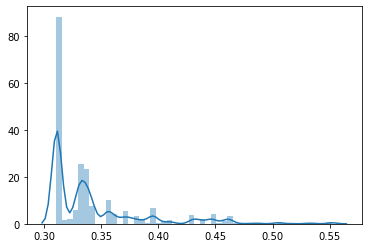

In [55]:
import seaborn as sns
sns.distplot(scaled_test)

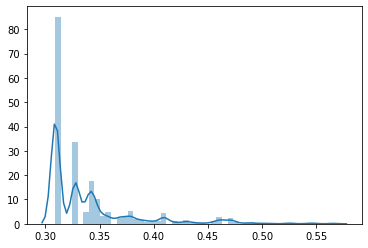

In [56]:
import seaborn as sns
sns.distplot(scaled_control)

In [ ]:
sns.distplot(model.predict(test.drop(['group', 'response_att'], axis=1)))

In [58]:
score, model, scaled_test, scaled_control, preds = validate_on_holdout(data, model, verbose=True)
print(score)
print('\nSpearman: ', spearmanr(scaled_test, scaled_control))
print('Pearson: ', pearsonr(scaled_test, scaled_control))

Обучаем модель на тестовой группе:
[0]	validation_0-logloss:0.630488	validation_0-auc:0.76453	validation_0-error:0.107095
[1]	validation_0-logloss:0.579403	validation_0-auc:0.771082	validation_0-error:0.107095
[2]	validation_0-logloss:0.536778	validation_0-auc:0.77185	validation_0-error:0.107095
[3]	validation_0-logloss:0.501513	validation_0-auc:0.778595	validation_0-error:0.107095
[4]	validation_0-logloss:0.471152	validation_0-auc:0.77934	validation_0-error:0.107095
[5]	validation_0-logloss:0.445704	validation_0-auc:0.779883	validation_0-error:0.107037
[6]	validation_0-logloss:0.423915	validation_0-auc:0.78015	validation_0-error:0.107066
[7]	validation_0-logloss:0.405434	validation_0-auc:0.780815	validation_0-error:0.107057
[8]	validation_0-logloss:0.389232	validation_0-auc:0.781391	validation_0-error:0.107037
[9]	validation_0-logloss:0.375581	validation_0-auc:0.781402	validation_0-error:0.107028
[10]	validation_0-logloss:0.363467	validation_0-auc:0.781933	validation_0-error:0.106989


In [59]:
scaled_control

array([0.14464216, 0.22388512, 0.3237787 , ..., 0.1781438 , 0.16905557,
       0.12195387], dtype=float32)

In [60]:
scaled_test

array([0.13602822, 0.23262553, 0.3334107 , ..., 0.16614938, 0.18549159,
       0.12883857], dtype=float32)

In [83]:
class ReverseModel:
    def __init__(self, param=None, blend_type='multiply', model=None):
        if param is None:
            param = {'n_jobs': -1, 'n_estimators': 10, 'eval_metric': ['ndcg', 'map'],
                     'objective': 'rank:ndcg', 'verbose': True}
        elif 'verbose' not in param:
            param['verbose'] = True

        self.model = model
            
        if self.model is None:
            self.model = xgboost.XGBClassifier(**param)
        self.param = param
        self.blend_type = blend_type
        
    def fit(self, data, group, eval_data=None):
        if 'group' in data.columns:
            data.drop('group', axis=1, inplace=True)
        group.replace({'test': 1, 'control': 0}, inplace=True)
        
        eval_data, eval_group = eval_data
        if 'group' in eval_data.columns:
            eval_data.drop('group', axis=1, inplace=True)
        eval_group.replace({'test': 1, 'control': 0}, inplace=True)

        if self.param['verbose']:
            print('Обучаем модель на тестовой группе:')
            
        self.model.fit(data, group,
                            eval_set=[(eval_data, eval_group)],
                            verbose = self.param['verbose'])

    def predict(self, data, verbose=False):
        data['response_att'] = 1
        came = self.model.predict_proba(data)[:, 1]
        data['response_att'] = 0
        not_came = self.model.predict_proba(data)[:, 1]
        return came, not_came
    

class ForwardModel:
    def __init__(self, param=None, blend_type='multiply', model=None):
        if param is None:
            param = {'n_jobs': -1, 'n_estimators': 10, 'eval_metric': ['ndcg', 'map'],
                     'objective': 'rank:ndcg', 'verbose': True}
        elif 'verbose' not in param:
            param['verbose'] = True

        self.model = model
            
        if self.model is None:
            self.model = xgboost.XGBClassifier(**param)
        self.param = param
        self.blend_type = blend_type
        
    def fit(self, data, y, eval_data=None):
        if 'response_att' in data.columns:
            data.drop('response_att', axis=1, inplace=True)
        
        data['group'].replace({'test': 1, 'control': 0}, inplace=True)
        
        eval_data, eval_y = eval_data
        if 'response_att' in eval_data.columns:
            eval_data.drop('response_att', axis=1, inplace=True)

        eval_data['group'].replace({'test': 1, 'control': 0}, inplace=True)
            
        if self.param['verbose']:
            print('Обучаем модель на тестовой группе:')
            
        self.model.fit(data, y,
                            eval_set=[(eval_data, eval_y)],
                            verbose = self.param['verbose'])

    def predict(self, data, verbose=False):
        data['group'] = 1
        test = self.model.predict_proba(data)[:, 1]
        data['group'] = 0
        control = self.model.predict_proba(data)[:, 1]
        return came, not_came

In [117]:
import xgboost
params = {'n_estimators': 5, 'eval_metric': ['logloss', 'auc', 'error'], 'verbose': True}
model = ForwardModel(params)

In [96]:
data['group']

0            test
1            test
2         control
3            test
4            test
           ...   
687024    control
687025       test
687026    control
687027    control
687028       test
Name: group, Length: 687029, dtype: object

In [118]:
train, test = train_test_split(concat, test_size=0.2,
                                   shuffle=True)
model.fit(train.drop('response_att', axis=1), train['response_att'],
              eval_data=(test.drop('response_att', axis=1), test['response_att']))

Обучаем модель на тестовой группе:
[0]	validation_0-logloss:0.671001	validation_0-auc:0.773578	validation_0-error:0.2906
[1]	validation_0-logloss:0.653188	validation_0-auc:0.77431	validation_0-error:0.289333
[2]	validation_0-logloss:0.637831	validation_0-auc:0.776992	validation_0-error:0.289263
[3]	validation_0-logloss:0.625842	validation_0-auc:0.779352	validation_0-error:0.288501
[4]	validation_0-logloss:0.615294	validation_0-auc:0.782697	validation_0-error:0.288099


In [120]:
pred_test, pred_control = model.predict(test.drop('response_att', axis=1))

In [125]:
final = pred_test < 0.5

In [130]:
final.sum() / final.shape[0]

0.027429661004614064

In [128]:
final.shape

(137406,)

In [102]:
data1 = data[data['response_att'] == 1]
data0 = data[data['response_att'] == 0]

In [104]:
data1.shape

(74368, 196)

In [103]:
data0.shape

(612661, 196)

In [105]:
concat = pd.concat([data1] * 8 + [data0])

In [108]:
concat = concat.sample(frac=1).reset_index(drop=True)

In [111]:
test, control = model.predict(test.drop('response_att', axis=1))

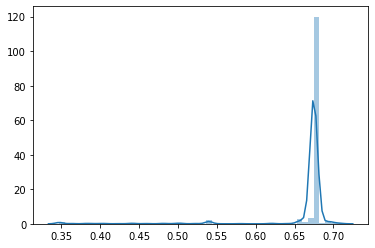

In [114]:
sns.distplot(test)

In [93]:
train['response_att'].value_counts()

0    490129
1     59494
Name: response_att, dtype: int64

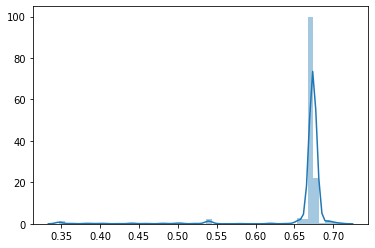

In [91]:
sns.distplot(contorl)

In [78]:
train['group'].value_counts()

1    412713
0    136910
Name: group, dtype: int64

In [79]:
test['group'].value_counts()

1    103179
0     34227
Name: group, dtype: int64

In [92]:
print('\nSpearman: ', spearmanr(test, contorl))
print('Pearson: ', pearsonr(test, contorl))


Spearman:  SpearmanrResult(correlation=0.9987481156835069, pvalue=0.0)
Pearson:  (0.9999690373929548, 0.0)


In [81]:
data_test = data[data['group'] == 'test']
data_control = data[data['group'] == 'control']

In [82]:
print(data_test.shape)
print(data_control.shape)

(515892, 196)
(171137, 196)


In [75]:
came, not_came = model.predict(test.drop('group', axis=1))